In [25]:
import nltk
import pandas as pd
# Do our imports for the code
from google.cloud import bigquery
from google.oauth2 import service_account
from collections import Counter
from nltk.corpus import stopwords
words = set(nltk.corpus.words.words())
sw2=set(stopwords.words('english'))
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt

In [2]:
# Set authentication info
service_path = "/Users/natebender/Desktop/repo/footprints/footprints_audience/"
service_file = 'footprintsrunning-d15e651db9a6.json' # change this to your authentication information  
gbq_proj_id = 'footprintsrunning' # change this to your poroject. 

# And this should stay the same. 
private_key = service_path + service_file

# Now we pass in our credentials so that Python has permission to access our project.
credentials = service_account.Credentials.from_service_account_file(service_path + service_file)

# And finally we establish our connection
gbqclient = bigquery.Client(credentials = credentials, project=gbq_proj_id)

In [4]:
table_id = 'footprintsrunning.twitter_scraping.trail_running'

In [5]:
table = gbqclient.get_table(table_id)  # Make an API request.

# View table properties
print(
    "Got table '{}.{}.{}'.".format(table.project, table.dataset_id, table.table_id)
)
print("Table schema: {}".format(table.schema))
print("Table description: {}".format(table.description))
print("Table has {} rows".format(table.num_rows))

Got table 'footprintsrunning.twitter_scraping.trail_running'.
Table schema: [SchemaField('user_id', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('screen_name', 'STRING', 'NULLABLE', None, (), None), SchemaField('location', 'STRING', 'NULLABLE', None, (), None), SchemaField('friends_count', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('followers_count', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('totaltweets', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('date_created', 'STRING', 'NULLABLE', None, (), None), SchemaField('tweet_id', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('retweetcount', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('full_text', 'STRING', 'NULLABLE', None, (), None), SchemaField('fulltext_clean', 'STRING', 'NULLABLE', None, (), None), SchemaField('desc_clean', 'STRING', 'NULLABLE', None, (), None)]
Table description: None
Table has 89354 rows


### Analysis playing around

In [6]:
# code I don't fully understand for setting up GBQ querying

import pydata_google_auth
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    # Set auth_local_webserver to True to have a slightly more convienient
    # authorization flow. Note, this doesn't work if you're running from a
    # notebook on a remote sever, such as over SSH or with Google Colab.
    auth_local_webserver=True,
)

In [8]:
# query GBQ table and place data into pandas df

query = """
    SELECT 
    screen_name,
    desc_clean,
    fulltext_clean
    FROM
    `footprintsrunning.twitter_scraping.trail_running`
"""

data = pd.read_gbq(query, project_id = gbq_proj_id, credentials=credentials, dialect = 'standard')


In [9]:
len(data)

89354

In [17]:
# experiment on smaller sample for starters

df_sample = data.sample(n=2000)

In [11]:
df_sample.head(10)

,screen_name,desc_clean,fulltext_clean
33021,adoublegym,trust process,day 2 365 amazing cause
88568,nirm,visual design digital user experience interfac...,list
22949,LunpiStore,shop new trends styles womens clother mens clo...,best quality best prices
81322,brandbazzar,sell ebay,asics men size fleece long sleeve black
80568,DRHM_Chennai,welcome official twitter handle drhm inspiring...,great way start year 2022 group run
34142,Miles_Mountains,full time run coach adventurer click info coac...,eric h amazing race green river marathon despi...
43562,TipTopShoes,est 1940 nycs tiptop shoes led danny wasserman...,always comfy super stylish bondi 7 back time a...
70982,uniquesportshop,100 authentic vintage retro sneakers sportswea...,nike elite pro running speedsuit men sizes ava...
8749,GossEmpire,provide inspiration motivation information tod...,badminton set plenty outdoor fun shop
21274,msgettinfitt,,client cam l results


In [18]:
# extract tweets into dedicated variable
tweets = [df_sample['fulltext_clean'] 
                 for i in df_sample ]

In [13]:
# Check desc stats on overall descriptions before splitting into groups
def get_patterns(text) :

    all_desc = text
    all_str = " ".join(all_desc[0])    
    clean = [w for w in all_str.split()]
    
    # Calculate your statistics here
    total_tokens = len(clean)
    unique_tokens = len(set(clean))
    clean_tok_len = [len(w) for w in clean]
    avg_token_len = np.mean(clean_tok_len)
    lex_diversity = len(set(clean))/len(clean)
    top_n = Counter(clean).most_common(20)
    
    
    # Now we'll fill out the dictionary. 
    results = {'tokens':total_tokens,
               'unique_tokens':unique_tokens,
               'avg_token_length':round(avg_token_len,2),
               'lexical_diversity':round(lex_diversity,2),
               'Top_n':top_n}

    return(results)

In [19]:
get_patterns(tweets)

{'tokens': 20778,
 'unique_tokens': 5344,
 'avg_token_length': 5.15,
 'lexical_diversity': 0.26,
 'Top_n': [('run', 508),
  ('running', 263),
  ('day', 205),
  ('amp', 176),
  ('today', 168),
  ('get', 157),
  ('miles', 146),
  ('year', 145),
  ('morning', 134),
  ('2022', 133),
  ('new', 127),
  ('good', 110),
  ('first', 109),
  ('time', 101),
  ('2', 96),
  ('great', 92),
  ('1', 89),
  ('like', 85),
  ('one', 85),
  ('back', 85)]}

In [20]:
# extract desc into dedicated variable
desc = [df_sample['desc_clean'] 
                 for i in df_sample ]

In [65]:
descdict = get_patterns(desc)

### Viz exploration

In [66]:
keys = descdict.keys()
values = list(descdict.values())
topn = values[4]

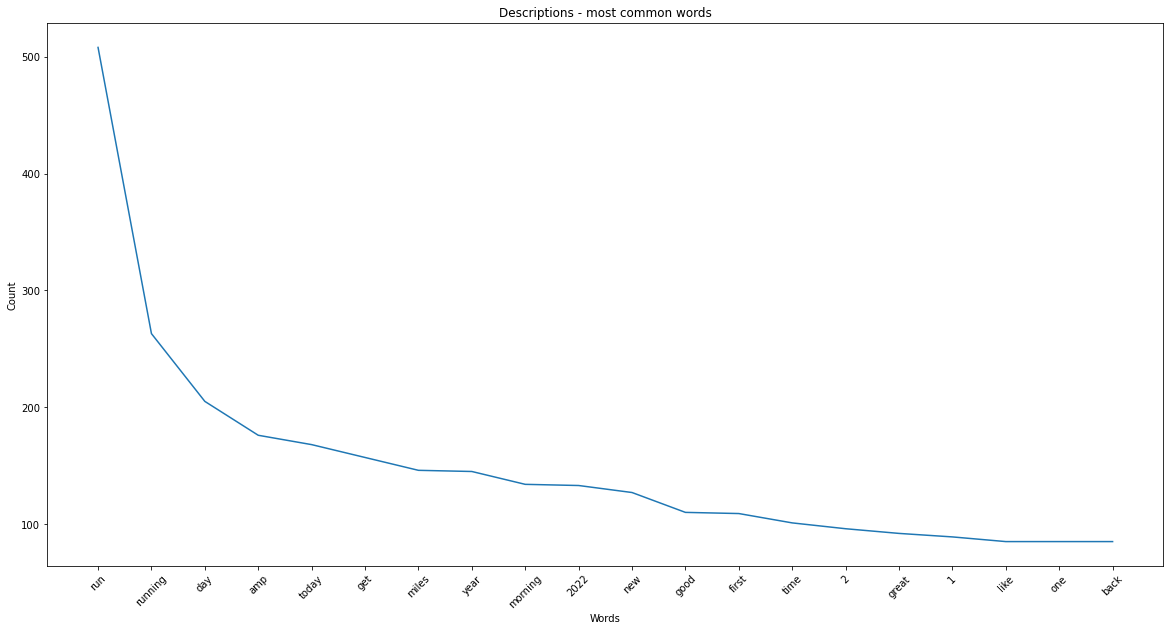

In [74]:
xs = [x for x, y in topn]
ys = [y for x, y in topn]

fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(xs, ys)
plt.setp(ax.get_xticklabels(), rotation = 45)

ax.set(title = "Descriptions - most common words",
       xlabel = "Words",
       ylabel = "Count")

plt.show()

In [69]:
tweetdict = get_patterns(tweets)

In [70]:
keys = tweetdict.keys()
values = list(tweetdict.values())
topn = values[4]

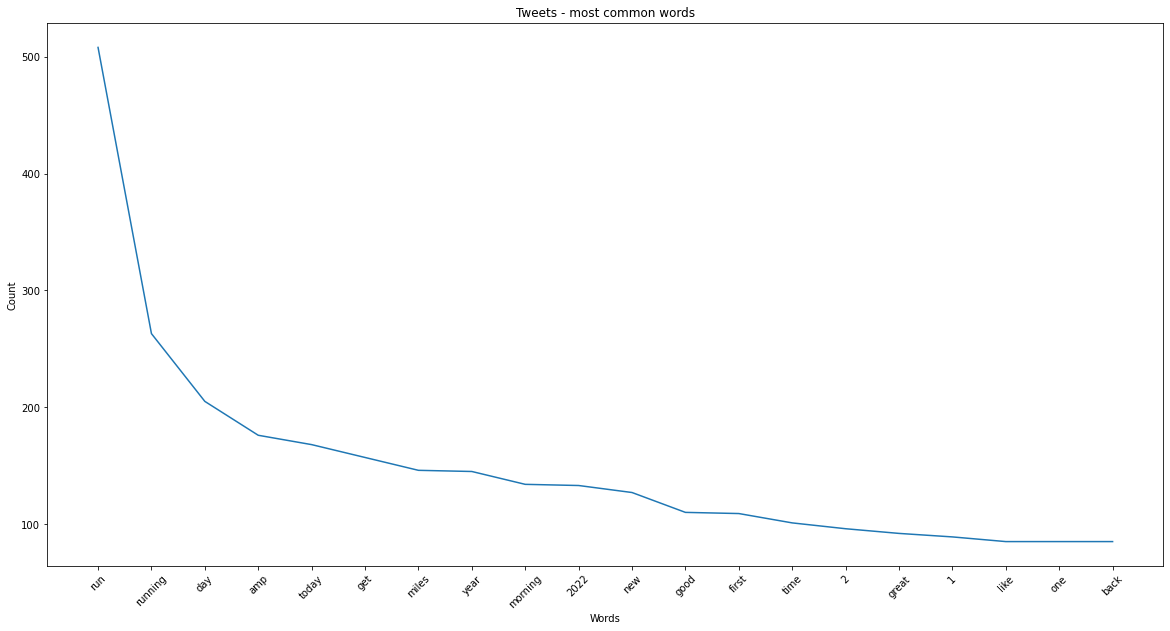

In [73]:
xs = [x for x, y in topn]
ys = [y for x, y in topn]

fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(xs, ys)
plt.setp(ax.get_xticklabels(), rotation = 45)

ax.set(title = "Tweets - most common words",
       xlabel = "Words",
       ylabel = "Count")

plt.show()